In [1]:
import numpy as np
import scipy as sp
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
from sklearn.neural_network import MLPClassifier

In [110]:
data_set = pd.read_csv("data/trn.csv", sep=',', header=0, low_memory=False)

In [111]:
data_set = pd.concat([data_set[data_set.y == 1].iloc[0:20000],data_set[data_set.y == 0].iloc[0:20000]])

In [112]:
data_set = data_set.drop('INDEX', 1)
data_set = data_set.drop('Unnamed: 0', 1)

# encontra as variavies categoricas
for col in data_set.columns:
    if ((data_set[col].quantile() == 1.0) | (data_set[col].quantile() == 0.0)):
        data_set[col] = data_set[col].astype('category')

In [6]:
from sklearn.model_selection import train_test_split

In [113]:
correlacoes = data_set.corr()['y']
correlacoes = correlacoes.drop(['y'])

In [114]:
corrr = correlacoes.apply(lambda x: (x*x))
corrr = corrr.to_frame()
todel = []
i = 0

for i in range(0,corrr.shape[0]):
    index = corrr.index[i]
    if corrr.iloc[i][0] < corrr.mean()[0]:
        todel.append(index)

In [115]:
dt2 = data_set.drop(columns=todel)

In [116]:
X = dt2.loc[:, dt2.columns !='y']
y = dt2.iloc[:, dt2.columns == 'y']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=42, stratify=y_train)

In [35]:
from sklearn.neural_network import MLPClassifier

In [118]:
mlp = MLPClassifier(hidden_layer_sizes=(245,), learning_rate_init=0.1, max_iter=10000, random_state=101, verbose=True, learning_rate='adaptive')
mlp.fit(X_train.values, y_train.values.ravel())

Iteration 1, loss = 1.09968637
Iteration 2, loss = 0.66476430
Iteration 3, loss = 0.65651180
Iteration 4, loss = 0.65651227
Iteration 5, loss = 0.65296370
Iteration 6, loss = 0.65694460
Iteration 7, loss = 0.65607780
Iteration 8, loss = 0.65728654
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(245,), learning_rate='adaptive',
       learning_rate_init=0.1, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=101,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [119]:
predicted = mlp.predict(X_test.values)
accuracy = accuracy_score(y_test.values, predicted)
print("Mean accuracy score: {:.3}".format(accuracy))

Mean accuracy score: 0.624


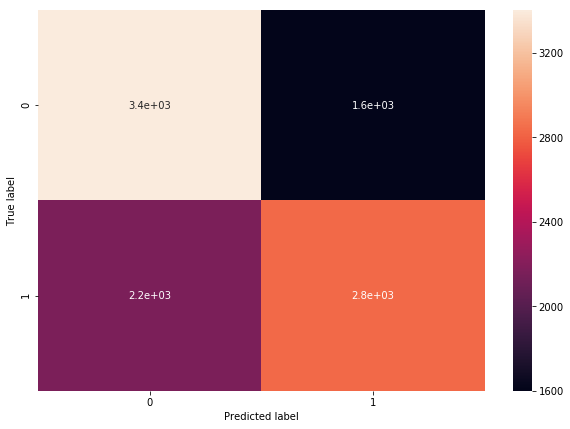

In [129]:
%matplotlib inline
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
cm
heatmap

In [121]:
y_pred_mlp = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_mlp, pos_label=1)

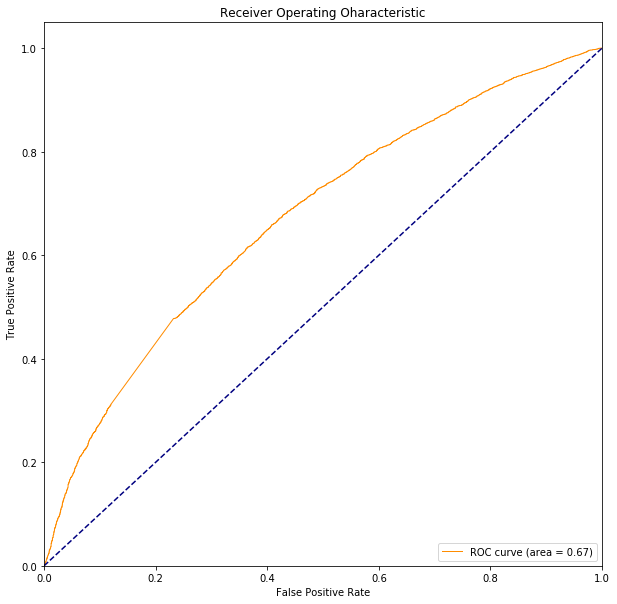

In [122]:
%matplotlib inline
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot(tpr, fpr, color='darkblue', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Oharacteristic')
plt.legend(loc="lower right")
plt.show()

In [123]:
from scipy import stats

def get_metrics(y, pred, probas):
    accuracy = accuracy_score(y.values, pred)
    recall = recall_score(y.values, pred)
    precision = precision_score(y.values, pred)
    f1 = f1_score(y.values, pred)
    aupr = average_precision_score(y.values, pred)
    fpr, tpr, thresholds = roc_curve(y.values, probas, pos_label=1)
    ks = stats.ks_2samp(y.iloc[:,0].values, probas)
    return (accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks)

In [125]:
y_pred_mlp = mlp.predict_proba(X_test)[:, 1]

In [128]:
accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks = get_metrics(y_test, predicted, y_pred_mlp)
print("Accuracy score: {:.3}".format(accuracy))
print("Recall score: {:.3}".format(recall))
print("Precision score: {:.3}".format(precision))
print("f1 score: {:.3}".format(f1))
print("Mean precison score: {:.3}".format(aupr))
print("KS: {:.30}".format(ks[0]))

Accuracy score: 0.624
Recall score: 0.567
Precision score: 0.639
f1 score: 0.601
Mean precison score: 0.579
KS: 0.5
